In [1]:
#pip install ipython-autotime

In [2]:
#pip install boto3

In [3]:
#pip install tensorframes

In [4]:
#pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [5]:
#pip install PyArrow

In [6]:
# magics for import statements
%load_ext dotenv
%dotenv

import os
import requests

ACCESS_CODE = os.getenv("accessCode")
SECRET_CODE = os.getenv("secretCode")

/home/ubuntu/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
%load_ext autotime

time: 262 µs (started: 2021-10-06 16:27:26 +00:00)


In [8]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
time: 466 µs (started: 2021-10-06 16:27:26 +00:00)


In [9]:
s3_url = "s3a://sosop8/sampleaws_5/*"

time: 342 µs (started: 2021-10-06 16:27:26 +00:00)


In [10]:
import time
tempsX = time.time()
def _time_():
    duration1 = time.time()-tempsX
    a = "temps de traitement       ",round(duration1/60,2), "minutes"
    return a 

# --------- findspark ---------------------------

import findspark
findspark.init('/home/ubuntu/spark-3.0.1-bin-hadoop2.7') 
_time_()

# --------- boto3 ---------------------------
import boto3
# --------- pyspark ---------------------------
import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, MinMaxScaler,PCA,VectorAssembler,StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.image import ImageSchema
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, SQLContext,Row,functions as F
from pyspark.sql.functions import col, pandas_udf, PandasUDFType,udf,lit, split,col
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
# --------- tensorflow ---------------------------
import tensorflow 
import tensorflow as tf
tensorflow.get_logger().setLevel('ERROR')
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Activation
import tensorframes as tfs
# --------- warnings ---------------------------
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# --------- Autres ---------------------------
import time
import os
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from io import StringIO
import types
from PIL import Image

time: 2.38 s (started: 2021-10-06 16:27:26 +00:00)


In [11]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"
        yield name
        
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

pyspark==3.0.1
tensorframes==0.2.9
tensorflow==2.6.0
requests==2.21.0
Pillow==8.3.2
pandas==0.25.3
numpy==1.19.5
matplotlib==3.4.3
keras==2.6.0
findspark==1.4.2
boto3==1.18.53
time: 3.21 ms (started: 2021-10-06 16:27:28 +00:00)


In [12]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

time: 704 µs (started: 2021-10-06 16:27:28 +00:00)


In [13]:
spark = (SparkSession
         .builder.master('local[*]')
         .appName('P8')
         .config('spark.hadoop.fs.s3a.access.key', ACCESS_CODE)
         .config('spark.hadoop.fs.s3a.secret.key', SECRET_CODE) 
         .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
         .getOrCreate())

_time_()

('temps de traitement       ', 0.19, 'minutes')

time: 8.77 s (started: 2021-10-06 16:27:28 +00:00)


In [14]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")

time: 15.4 ms (started: 2021-10-06 16:27:37 +00:00)


In [15]:
def model_fn():
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

def preprocess(content):
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)
        

import boto3
from botocore.exceptions import NoCredentialsError


def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_CODE,
                      aws_secret_access_key=SECRET_CODE)

    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False


time: 361 ms (started: 2021-10-06 16:27:37 +00:00)


In [16]:
model = ResNet50(include_top=False)
bc_model_weights = sc.broadcast(model.get_weights())
_time_()

('temps de traitement       ', 0.23, 'minutes')

time: 2.2 s (started: 2021-10-06 16:27:37 +00:00)


In [17]:
print('Load img ======== 1 ========')

images = spark.read.format("binaryFile") \
      .option("pathGlobFilter", "*.jpg") \
      .option("recursiveFileLookup", "true") \
      .load(s3_url)

_time_()

Load img ======== 1 ========


('temps de traitement       ', 0.29, 'minutes')

time: 3.52 s (started: 2021-10-06 16:27:40 +00:00)


In [18]:
print(images.show(3))
print('Ajout Target ======== 2 ========')
df_1 =  images.withColumn('target', split(images['path'], '/')[4])
print((df_1.count(), len(df_1.columns)))
print(df_1.show(3))

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://sosop8/samp...|2021-10-04 18:30:24|  6785|[FF D8 FF E0 00 1...|
|s3a://sosop8/samp...|2021-10-04 18:30:19|  6585|[FF D8 FF E0 00 1...|
|s3a://sosop8/samp...|2021-10-04 18:30:20|  6580|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 3 rows

None
Ajout Target ======== 2 ========
(68, 5)
+--------------------+-------------------+------+--------------------+----------+
|                path|   modificationTime|length|             content|    target|
+--------------------+-------------------+------+--------------------+----------+
|s3a://sosop8/samp...|2021-10-04 18:30:24|  6785|[FF D8 FF E0 00 1...|Watermelon|
|s3a://sosop8/samp...|2021-10-04 18:30:19|  6585|[FF D8 FF E0 00 1...| Pineapple|
|s3a://sosop8/samp...|

In [19]:
print('Isol Target ======== 3 ========')
y = df_1.select(col("target"))
print('y   ', y.show(2))

Isol Target ======== 3 ========
+----------+
|    target|
+----------+
|Watermelon|
| Pineapple|
+----------+
only showing top 2 rows

y    None
time: 286 ms (started: 2021-10-06 16:27:48 +00:00)


In [20]:
print('Creation UDF ======== 4 ========')
df_2 = df_1.repartition(10).select(col("path"), featurize_udf("content").alias("features"),col("target"))
print('features_df   ', df_2.show(2))

# 10 => 16s
# 100 => 1m20

Creation UDF ======== 4 ========
+--------------------+--------------------+----------+
|                path|            features|    target|
+--------------------+--------------------+----------+
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|     Cocos|
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|Watermelon|
+--------------------+--------------------+----------+
only showing top 2 rows

features_df    None
time: 9.23 s (started: 2021-10-06 16:27:49 +00:00)


In [21]:
print('Convert Dense ======== 5 ========')
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
df_3 = df_2.withColumn('features_dense', ud_f('features'))
print('dense_df   ', df_3.show(2))

Convert Dense ======== 5 ========
+--------------------+--------------------+----------+--------------------+
|                path|            features|    target|      features_dense|
+--------------------+--------------------+----------+--------------------+
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|     Cocos|[0.0,0.0,0.0,0.0,...|
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|Watermelon|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+----------+--------------------+
only showing top 2 rows

dense_df    None
time: 8.87 s (started: 2021-10-06 16:27:58 +00:00)


In [22]:
print('Standard Scal ======== 6 ========')
standardizer = StandardScaler(inputCol="features_dense", outputCol="feat_scal",withStd=True, withMean=True)
df_4 = standardizer.fit(df_3).transform(df_3)
print('Standard_df   ', df_4.show(2))

Standard Scal ======== 6 ========
+--------------------+--------------------+----------+--------------------+--------------------+
|                path|            features|    target|      features_dense|           feat_scal|
+--------------------+--------------------+----------+--------------------+--------------------+
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|     Cocos|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|Watermelon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+----------+--------------------+--------------------+
only showing top 2 rows

Standard_df    None
time: 35 s (started: 2021-10-06 16:28:07 +00:00)


PCA ======== 7.0 ========
--- reduc
---> variance
8 = 90% exp 


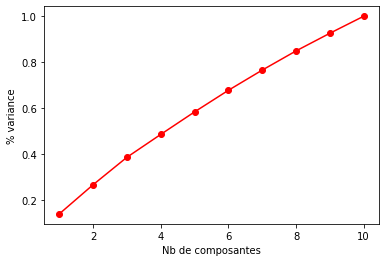

8
time: 18min 59s (started: 2021-10-06 16:28:42 +00:00)


In [23]:
print('PCA ======== 7.0 ========')
k = 10
pca = PCA(k = k, inputCol = 'feat_scal', outputCol = 'feat_pca')
reduc = pca.fit(df_4)
print('--- reduc')
variance = reduc.explainedVariance
print('---> variance')
for i in range(k):
    a = variance.cumsum()[i]
    if a >= 0.90:
        print("{} = 90% exp ".format(i))
        comp_val = i 
        break


# visuel
plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
plt.xlabel("Nb de composantes")
plt.ylabel("% variance")
plt.show(block=False)

print(i)

# time: 5min 35s

In [24]:
print('PCA ======== 7.1 ========')
print(i)
pca = PCA(k=i, inputCol='feat_scal', outputCol='feat_reduit')
pca_model = pca.fit(df_4)
df_5 = pca_model.transform(df_4)
print('Pca_df   ', df_5.show(2))

PCA ======== 7.1 ========
8
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|                path|            features|    target|      features_dense|           feat_scal|         feat_reduit|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|     Cocos|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[36.3895569360514...|
|s3a://sosop8/samp...|[0.0, 0.0, 0.0, 0...|Watermelon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[28.0266080544407...|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 2 rows

Pca_df    None
time: 19min 43s (started: 2021-10-06 16:47:41 +00:00)


In [25]:
print('Select Col ======== 8 ========')
df_6 = df_5.select(col("target"),col("feat_reduit"),col("path"))
df_6.show(5)

Select Col ======== 8 ========
+----------+--------------------+--------------------+
|    target|         feat_reduit|                path|
+----------+--------------------+--------------------+
|     Cocos|[36.3895569360514...|s3a://sosop8/samp...|
|Watermelon|[28.0266080544407...|s3a://sosop8/samp...|
| Mandarine|[13.1453513725491...|s3a://sosop8/samp...|
|   Avocado|[33.6549620642777...|s3a://sosop8/samp...|
|     Lemon|[3.88892123235365...|s3a://sosop8/samp...|
+----------+--------------------+--------------------+
only showing top 5 rows

time: 5.1 s (started: 2021-10-06 17:07:24 +00:00)


In [26]:
print('Indexer======== 9 ========')
indexer = StringIndexer(inputCol="target", outputCol="target_Idx") 
df_7 = indexer.fit(df_6).transform(df_6) 
df_7.show(2)

Indexer======== 9 ========
+----------+--------------------+--------------------+----------+
|    target|         feat_reduit|                path|target_Idx|
+----------+--------------------+--------------------+----------+
|     Cocos|[36.3895569360514...|s3a://sosop8/samp...|       2.0|
|Watermelon|[28.0266080544407...|s3a://sosop8/samp...|      16.0|
+----------+--------------------+--------------------+----------+
only showing top 2 rows

time: 6.26 s (started: 2021-10-06 17:07:29 +00:00)


In [27]:
print('Select Col - part 2 ======== 10 ========')
df_8 = df_7.select(col("target_Idx"),col("feat_reduit"),col("path"))
df_8.show(5)

Select Col - part 2 ======== 10 ========
+----------+--------------------+--------------------+
|target_Idx|         feat_reduit|                path|
+----------+--------------------+--------------------+
|       2.0|[36.3895569360514...|s3a://sosop8/samp...|
|      16.0|[28.0266080544407...|s3a://sosop8/samp...|
|       9.0|[13.1453513725491...|s3a://sosop8/samp...|
|       0.0|[33.6549620642777...|s3a://sosop8/samp...|
|       8.0|[3.88892123235365...|s3a://sosop8/samp...|
+----------+--------------------+--------------------+
only showing top 5 rows

time: 5.35 s (started: 2021-10-06 17:07:36 +00:00)


In [28]:
print(' train_data, test_data ======== 11 ========')
train_data, test_data = df_8.randomSplit([.75,.25])

 train_data, test_data ======== 11 ========
time: 21.7 ms (started: 2021-10-06 17:07:41 +00:00)


In [29]:
print(' LogisticRegression ======== 12 ========')
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="target_Idx",featuresCol="feat_reduit")
LogFModel = lr.fit(train_data)
predictions = LogFModel.transform(test_data)
selected = predictions.select("target_Idx", "prediction", "probability")

evaluator = MulticlassClassificationEvaluator(labelCol="target_Idx", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

Def_sc = str(accuracy)
print(selected.show(10))
print("Test set accuracy = " + str(accuracy))

 LogisticRegression ======== 12 ========
+----------+----------+--------------------+
|target_Idx|prediction|         probability|
+----------+----------+--------------------+
|       0.0|      11.0|[8.02005742493837...|
|       1.0|       8.0|[4.92553234283082...|
|       2.0|       2.0|[5.18129703986905...|
|       5.0|       5.0|[8.65189017001823...|
|       8.0|       8.0|[2.37113666783210...|
|      13.0|      13.0|[7.56585836629978...|
|       6.0|       6.0|[0.0,0.0,0.0,0.0,...|
|       8.0|       8.0|[5.94480995567005...|
|      10.0|      10.0|[9.42867594927807...|
|      16.0|      16.0|[1.82928625618228...|
+----------+----------+--------------------+
only showing top 10 rows

None
Test set accuracy = 0.8125
time: 1min 21s (started: 2021-10-06 17:07:41 +00:00)


In [30]:
print('Export Local ======== 13 ========')
data_to_csv = df_8.toPandas()
data_to_csv.to_csv('/home/ubuntu/csv_folder/data_to_csv.csv')

Export Local ======== 13 ========
time: 25.2 s (started: 2021-10-06 17:09:03 +00:00)


In [31]:
print('Export S3 ======== 14 ========')
uploaded = upload_to_aws('/home/ubuntu/csv_folder/data_to_csv.csv', 'sosop8', 'export_csv/data_to_csv.csv')



Export S3 ======== 14 ========
Upload Successful
time: 336 ms (started: 2021-10-06 17:09:28 +00:00)


In [32]:
print('Delete local ======== 13 ========')

Delete local ======== 13 ========
time: 528 µs (started: 2021-10-06 17:09:29 +00:00)


In [33]:
!rm /home/ubuntu/csv_folder/data_to_csv.csv

time: 123 ms (started: 2021-10-06 17:09:29 +00:00)
